In [1]:
from keras.models   import Model, Sequential, load_model
from keras.layers   import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, UpSampling2D, Reshape
from keras.utils    import plot_model
from keras.datasets import mnist

from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing     import OneHotEncoder

import h5py

import numpy  as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image 

%matplotlib inline

Using TensorFlow backend.


# CNN model for MNIST data 

## Load data

In [10]:
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = mnist.load_data()

x_train = np.reshape( 
    (x_train_orig.astype('float32') / 255.), 
    (len(x_train_orig), x_train_orig.shape[1], x_train_orig.shape[2], 1) 
)

x_test  = np.reshape( 
    (x_test_orig.astype('float32')  / 255.), 
    (len(x_test_orig),  x_test_orig.shape[1],  x_test_orig.shape[2],  1) 
)

y_train = OneHotEncoder(sparse=False,categories='auto').fit_transform(y_train_orig.reshape(-1, 1))
y_test  = OneHotEncoder(sparse=False,categories='auto').fit_transform(y_test_orig.reshape(-1, 1))

## CNN Model

```python
model = Sequential()
model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28,28,1)) )
model.add( MaxPooling2D() )
model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same') )
model.add( MaxPooling2D() )
model.add( Dropout(0.25) )
model.add( Flatten() )
model.add( Dense(512, activation='relu')
model.add( Dense(128, activation='relu')
model.add( Dense(32,  activation='relu')
model.add( Dense(10,  activation='softmax') )
```

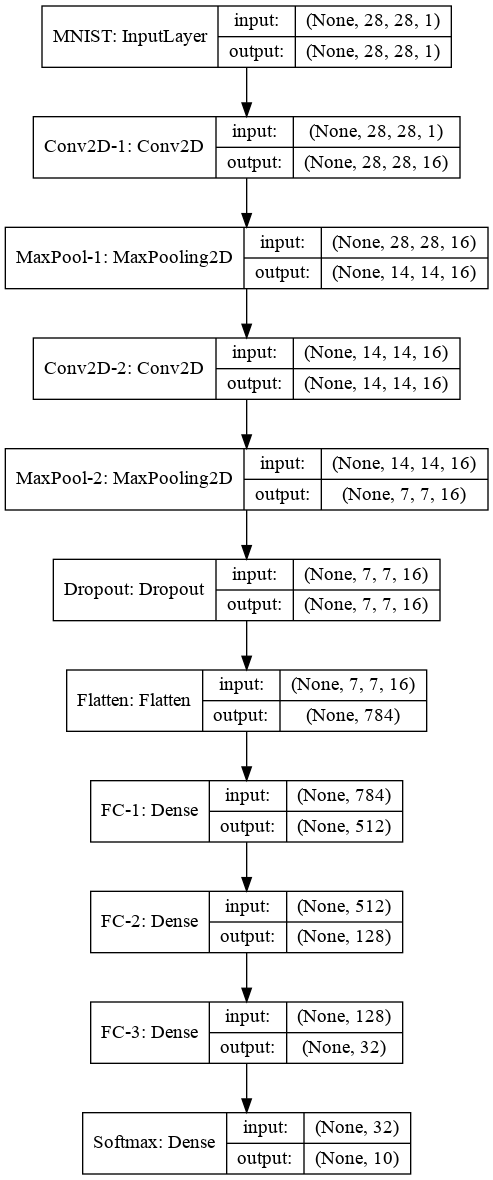

In [158]:
mnist_inputs = Input(name='MNIST', shape=(28,28,1,))

x1 = mnist_inputs
x1 = Conv2D( 16, kernel_size=(3, 3),
    activation='relu', padding='same', name='Conv2D-1' )(x1)
x1 = MaxPooling2D(                     name='MaxPool-1')(x1)
x1 = Conv2D( 16, kernel_size=(3, 3),
    activation='relu', padding='same', name='Conv2D-2' )(x1)
x1 = MaxPooling2D(                     name='MaxPool-2')(x1)
x1 = Dropout(0.25,                     name='Dropout'  )(x1)
x1 = Flatten(                          name='Flatten'  )(x1)
x1 = Dense(512, activation='relu',     name='FC-1'     )(x1)
x1 = Dense(128, activation='relu',     name='FC-2'     )(x1)
x1 = Dense(32,  activation='relu',     name='FC-3'     )(x1)
x1 = Dense(10,  activation='softmax',  name='Softmax'  )(x1)
mnist_pred = x1

mnist_cnn_model = Model(inputs=mnist_inputs, outputs=mnist_pred)

plot_model(mnist_cnn_model, show_shapes=True, to_file='mnist_cnn_model.png')
Image(filename='mnist_cnn_model.png')


## Train & validation

In [159]:
mnist_cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer='adadelta',
    metrics=['accuracy']
)

history = mnist_cnn_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    batch_size=128,
    shuffle=True, 
    verbose=2,
)

print ()
score = mnist_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:',     score[0])
print('Test accuracy:', score[1])

mnist_cnn_model.save('mnist_cnn_model.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 8s - loss: 0.3150 - acc: 0.8969 - val_loss: 0.0566 - val_acc: 0.9823
Epoch 2/10
 - 8s - loss: 0.0784 - acc: 0.9756 - val_loss: 0.0375 - val_acc: 0.9873
Epoch 3/10
 - 8s - loss: 0.0582 - acc: 0.9812 - val_loss: 0.0401 - val_acc: 0.9880
Epoch 4/10
 - 8s - loss: 0.0463 - acc: 0.9854 - val_loss: 0.0308 - val_acc: 0.9900
Epoch 5/10
 - 8s - loss: 0.0391 - acc: 0.9876 - val_loss: 0.0303 - val_acc: 0.9903
Epoch 6/10
 - 8s - loss: 0.0352 - acc: 0.9889 - val_loss: 0.0298 - val_acc: 0.9902
Epoch 7/10
 - 8s - loss: 0.0311 - acc: 0.9903 - val_loss: 0.0240 - val_acc: 0.9929
Epoch 8/10
 - 8s - loss: 0.0275 - acc: 0.9912 - val_loss: 0.0249 - val_acc: 0.9917
Epoch 9/10
 - 8s - loss: 0.0245 - acc: 0.9921 - val_loss: 0.0380 - val_acc: 0.9897
Epoch 10/10
 - 8s - loss: 0.0228 - acc: 0.9925 - val_loss: 0.0248 - val_acc: 0.9917

Test loss: 0.02482850314014504
Test accuracy: 0.9917


In [160]:
# data1 = []
# data2 = []

# pred = np.argmax(model.predict(x_test), axis=1)

# for index in np.where(pred != y_test_orig)[0]:
#     data1.append(y_test_orig[index])
#     data2.append(pred[index])


# data1 = pd.Series(data1).value_counts().sort_index().reset_index()
# data2 = pd.Series(data2).value_counts().sort_index().reset_index().set_index('index').reindex(data1.index).fillna(0).reset_index()

# sns.barplot(data=data1,x='index',y=0)
# plt.show()
# sns.barplot(data=data2,x='index',y=0)

# plt.show()

In [161]:
# n = 0
# for index in np.where(np.argmax(mnist_cnn_model.predict(x_test), axis=1) != y_test_orig)[0]:
#     plt.imshow(x_test_orig[index])
#     print (str(index)+": y = " + str(y_test_orig[index]) + ', ' + str(np.argmax(mnist_cnn_model.predict(x_test), axis=1)[index]) )
#     plt.show()

#     n += 1
#     if n>5:
#         break

---
---
---

# CNN model for N-signs
- Datasets: https://www.floydhub.com/deeplearningai/datasets/signs
- Github: https://github.com/mesolmaz/HandSigns_CNN


***Warnings***

> Small dataset ! Work well in CNN, but not work well in Autoencoder

## Load data

In [401]:
f1 = h5py.File("train_signs.h5", "r")
f2 = h5py.File("test_signs.h5",  "r")

# Loading the data (signs)
X_train_orig = np.array(f1['train_set_x'])
Y_train_orig = np.array(f1['train_set_y'])
X_test_orig  = np.array(f2['test_set_x'])
Y_test_orig  = np.array(f2['test_set_y'])

# print ("Training Data Feature Size = " + str(X_train_orig.shape))
# print ("Training Data Class Size = " + str(Y_train_orig.shape))
# print ("Test Data Feature Size = " + str(X_test_orig.shape))
# print ("Test Data Class Size = " + str(Y_test_orig.shape))

X_train = (X_train_orig / 255).astype('float32')
X_test  = (X_test_orig  / 255).astype('float32')

test_datagen  = ImageDataGenerator( rescale=1./255, )
train_datagen = ImageDataGenerator( rescale=1./255,
    width_shift_range  = 0.15,
    height_shift_range = 0.15,
    shear_range        = 0.3,
    zoom_range         = 0.1,
    rotation_range     = 30,
    horizontal_flip    = True,
    vertical_flip      = False,
    fill_mode          = 'nearest',
)

train_datagen.fit(X_train_orig)
test_datagen.fit(X_test_orig)


Y_train = OneHotEncoder(sparse=False,categories='auto').fit_transform(Y_train_orig.reshape(-1, 1))
Y_test  = OneHotEncoder(sparse=False,categories='auto').fit_transform(Y_test_orig.reshape(-1, 1))

# (Y_train.argmax(axis=1) == Y_train_orig).all()

# print ("number of training examples = " + str(X_train.shape[0]))
# print ("number of test examples = " + str(X_test.shape[0]))
# print ("X_train shape: " + str(X_train.shape))
# print ("Y_train shape: " + str(Y_train.shape))
# print ("X_test shape: " + str(X_test.shape))
# print ("Y_test shape: " + str(Y_test.shape))

# # Example of a picture
# index = 1
# plt.imshow(X_train_orig[index])
# print ("y = " + str(Y_train_orig[index]))

In [402]:
# len(x_batch)

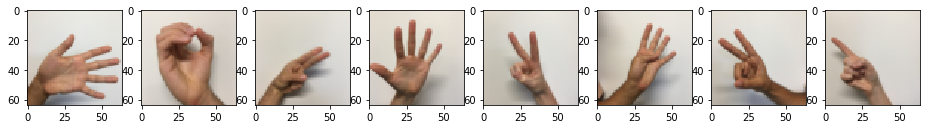

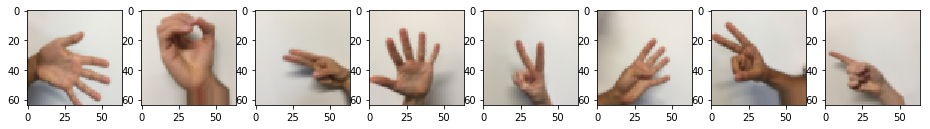

In [403]:
data_iter = train_datagen.flow(X_train_orig, batch_size=8, shuffle=False)

x_batch = data_iter.next()

plt.figure(figsize=(16,8))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X_train_orig[i].reshape(64,64,3), cmap='gray')
plt.show()

plt.figure(figsize=(16,8))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(x_batch[i].reshape(64,64,3), cmap='gray')
plt.show()


## CNN Model


```python
model = Sequential()
model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(64,64,3)) )
model.add( MaxPooling2D() )
model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',) )
model.add( MaxPooling2D() )
model.add( Dropout(0.5) )
model.add( Flatten() )
model.add( Dense(128, activation='relu') )
model.add( Dense(32,  activation='relu') )
model.add( Dense(6,   activation='softmax') )
```

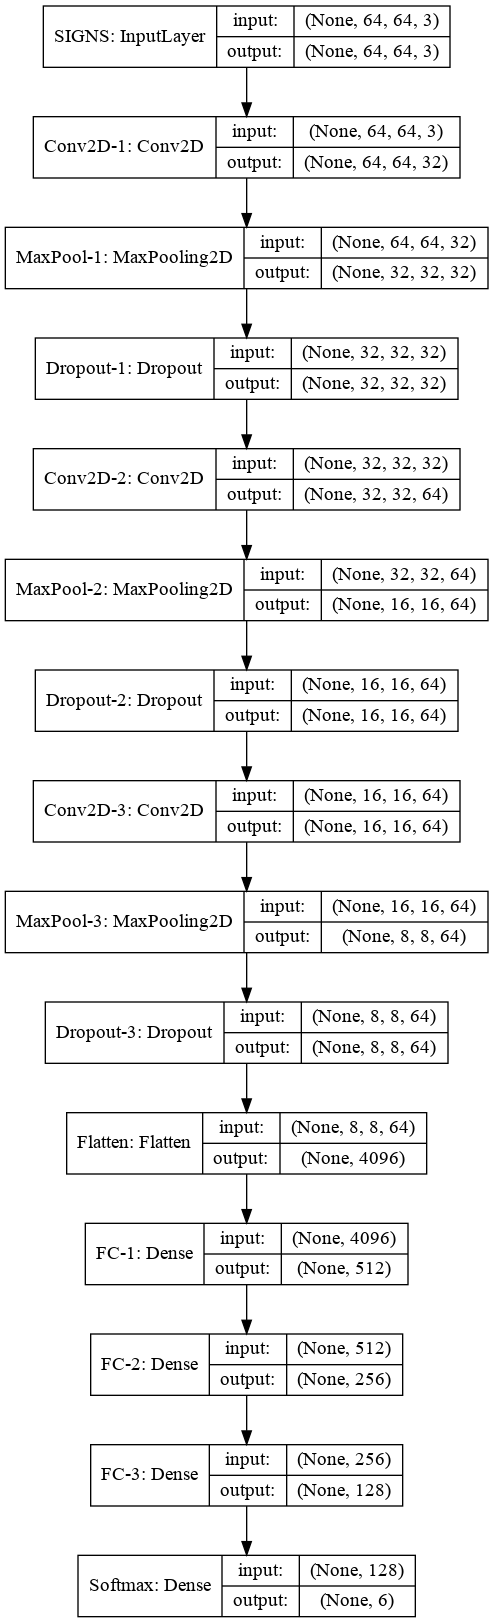

In [404]:
signs_inputs = Input(name='SIGNS', shape=(64,64,3,))

x2 = signs_inputs
x2 = Conv2D( 32, kernel_size=(3, 3),  
    activation='relu', padding='same', name='Conv2D-1' )(x2)
x2 = MaxPooling2D(                     name='MaxPool-1')(x2)
x2 = Dropout(0.2,                      name='Dropout-1')(x2)
x2 = Conv2D( 64, kernel_size=(3, 3),  
    activation='relu', padding='same', name='Conv2D-2' )(x2)
x2 = MaxPooling2D(                     name='MaxPool-2')(x2)
x2 = Dropout(0.2,                      name='Dropout-2')(x2)
x2 = Conv2D( 64, kernel_size=(3, 3),  
    activation='relu', padding='same', name='Conv2D-3' )(x2)
x2 = MaxPooling2D(                     name='MaxPool-3')(x2)
x2 = Dropout(0.2,                      name='Dropout-3')(x2)
x2 = Flatten(                          name='Flatten'  )(x2)
x2 = Dense(512, activation='relu',     name='FC-1'     )(x2)
# x2 = Dropout(0.2,                      name='Dropout-4')(x2)
x2 = Dense(256, activation='relu',     name='FC-2'     )(x2)
x2 = Dense(128, activation='relu',     name='FC-3'     )(x2)
x2 = Dense(6,   activation='softmax',  name='Softmax'  )(x2)
signs_pred = x2

signs_cnn_model = Model(inputs=signs_inputs, outputs=signs_pred)

plot_model(signs_cnn_model, show_shapes=True, to_file='signs_cnn_model.png')
Image(filename='signs_cnn_model.png')

In [405]:
# signs_cnn_model.summary()

In [406]:
signs_cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer='adadelta',
    metrics=['accuracy']
)

history = signs_cnn_model.fit_generator(
    train_datagen.flow(X_train_orig, Y_train, batch_size=32, shuffle=True),
    validation_data=(X_test, Y_test),
    epochs=50,
    use_multiprocessing=True,
    verbose=2,
)

print ()
score = signs_cnn_model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:',     score[0])
print('Test accuracy:', score[1])

signs_cnn_model.save('signs_cnn_model.h5')

Epoch 1/50
 - 8s - loss: 1.8037 - acc: 0.1639 - val_loss: 1.7917 - val_acc: 0.1667
Epoch 2/50
 - 4s - loss: 1.7940 - acc: 0.1569 - val_loss: 1.7910 - val_acc: 0.1667
Epoch 3/50
 - 4s - loss: 1.7942 - acc: 0.1682 - val_loss: 1.7917 - val_acc: 0.1667
Epoch 4/50
 - 4s - loss: 1.7922 - acc: 0.1651 - val_loss: 1.7906 - val_acc: 0.1667
Epoch 5/50
 - 4s - loss: 1.7933 - acc: 0.1948 - val_loss: 1.7904 - val_acc: 0.2667
Epoch 6/50
 - 4s - loss: 1.7862 - acc: 0.2114 - val_loss: 1.7624 - val_acc: 0.2083
Epoch 7/50
 - 4s - loss: 1.7884 - acc: 0.2028 - val_loss: 1.7939 - val_acc: 0.1667
Epoch 8/50
 - 4s - loss: 1.7532 - acc: 0.2362 - val_loss: 1.6261 - val_acc: 0.4417
Epoch 9/50
 - 4s - loss: 1.7303 - acc: 0.2650 - val_loss: 1.6123 - val_acc: 0.3583
Epoch 10/50
 - 4s - loss: 1.6732 - acc: 0.3095 - val_loss: 1.4585 - val_acc: 0.4750
Epoch 11/50
 - 4s - loss: 1.6631 - acc: 0.3321 - val_loss: 1.3785 - val_acc: 0.5000
Epoch 12/50
 - 4s - loss: 1.4977 - acc: 0.3833 - val_loss: 1.3120 - val_acc: 0.5250
E

27: y = 2, 1


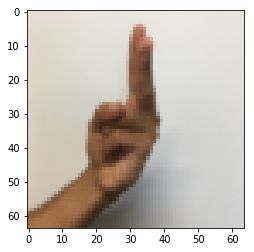

46: y = 2, 1


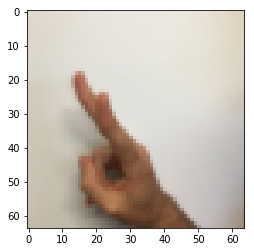

60: y = 5, 4


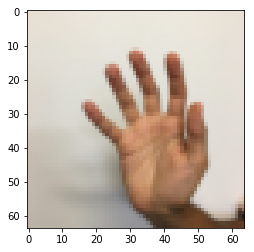

61: y = 5, 4


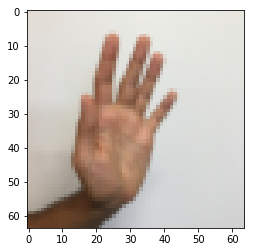

In [415]:
# # Plot training & validation accuracy values
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper right')
# plt.show()

n = 0
for index in np.where(np.argmax(signs_cnn_model.predict(X_test), axis=1) != Y_test_orig)[0]:
    plt.imshow(X_test_orig[index])
    print (str(index)+": y = " + str(Y_test_orig[index]) + ', ' + str(np.argmax(signs_cnn_model.predict(X_test), axis=1)[index]) )
    plt.show()

    n += 1
    if n>5:
        break

---
---
---

# Building Autoencoders in Keras


### [Code & Text Source](https://blog.keras.io/building-autoencoders-in-keras.html)

## What are autoencoders?

![img](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

"Autoencoding" is a data compression algorithm where the compression and decompression functions are:
1. data-specific
> they will only be able to compress data similar to what they have been trained on
2. lossy
3. learned automatically from examples rather than engineered by a human.

Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

---

To build an autoencoder, you need three things: 
- an encoding function
- a decoding function
- a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function)

## What are autoencoders good for?

- data denoising
- dimensionality reduction for data visualization

---

# Autoencoder for MNIST data 

- The CNN model


In [238]:
mnist_cnn_model = load_model('mnist_cnn_model.h5')
mnist_encoder = Model(inputs=mnist_cnn_model.input, outputs=mnist_cnn_model.get_layer('FC-3').output)
mnist_encoder.trainable = False
mnist_encoder.compile(optimizer='adadelta', loss='mse')

In [239]:
mnist_encoder.trainable_weights

[]

In [240]:
# mnist_encoder.summary()

In [241]:
mnist_z = mnist_encoder.output
x1 = Dense(128, activation='relu',         name='dFC-1'     )(mnist_z) 
x1 = Dense(512, activation='relu',         name='dFC-2'     )(x1)
x1 = Dense(784, activation='relu',         name='dFC-3'     )(x1)
x1 = Reshape((7, 7, 16),                   name='Reshape'   )(x1)
x1 = Conv2D( 16, kernel_size=(3, 3), 
    activation='relu',     padding='same', name='deConv2D-1')(x1)
x1 = UpSampling2D(                         name='UpSample-1')(x1)
x1 = Conv2D( 16, kernel_size=(3, 3), 
    activation='relu',     padding='same', name='deConv2D-2')(x1)
x1 = UpSampling2D(                         name='UpSample-2')(x1)
x1 = Conv2D( 1, kernel_size=(3, 3), 
    activation='sigmoid',  padding='same', name='deConv2D-3')(x1)
mnist_decoded = x1

In [242]:
mnist_autoencoder = Model(inputs=mnist_cnn_model.input, outputs=mnist_decoded)

flag = 0
for layer in mnist_autoencoder.layers:
    if flag == 0:
        if layer.name != 'dFC-1':
            layer.trainable = False
        else:
            flag = 1
    else:
        pass

mnist_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [243]:
# mnist_autoencoder.summary()
# plot_model(mnist_autoencoder, show_shapes=True, to_file='mnist_autoencoder.png')
# Image(filename='mnist_autoencoder.png')

In [244]:
mnist_autoencoder.fit(
    x_train, x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    verbose=2,
    validation_data=(x_test, x_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 23s - loss: 0.2170 - val_loss: 0.1891
Epoch 2/10
 - 21s - loss: 0.1849 - val_loss: 0.1714
Epoch 3/10
 - 21s - loss: 0.1752 - val_loss: 0.1642
Epoch 4/10
 - 21s - loss: 0.1696 - val_loss: 0.1665
Epoch 5/10
 - 21s - loss: 0.1660 - val_loss: 0.1573
Epoch 6/10
 - 21s - loss: 0.1633 - val_loss: 0.1530
Epoch 7/10
 - 21s - loss: 0.1613 - val_loss: 0.1512
Epoch 8/10
 - 21s - loss: 0.1596 - val_loss: 0.1526
Epoch 9/10
 - 21s - loss: 0.1583 - val_loss: 0.1492
Epoch 10/10
 - 21s - loss: 0.1570 - val_loss: 0.1487


In [245]:
mnist_Z_input = Input(name='MNIST-Z', shape=(32, ))

x1 = mnist_autoencoder.get_layer('dFC-1')(mnist_Z_input)

flag = 0
for layer in mnist_autoencoder.layers:
    if flag == 0:
        if layer.name != 'dFC-1':
            pass
        else:
            flag = 1
    else:
        x1 = layer(x1)

mnist_decoder = Model(inputs=mnist_Z_input, outputs=x1)

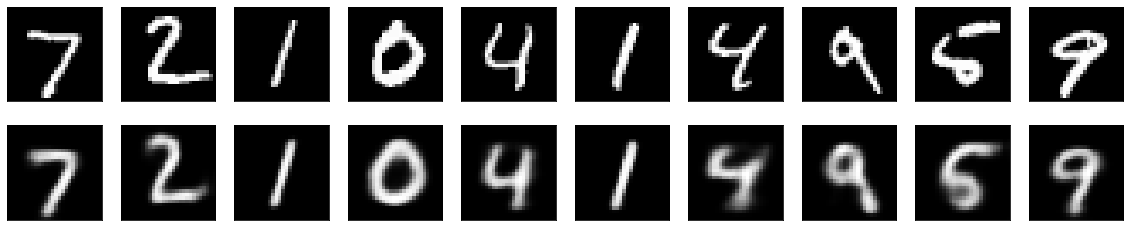

In [246]:
encoded_imgs = mnist_encoder.predict(x_test)
decoded_imgs = mnist_decoder.predict(encoded_imgs)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

---

# Autoencoder for N-signs data 

- The CNN model



In [416]:
signs_cnn_model = load_model('signs_cnn_model.h5')
signs_encoder = Model(inputs=signs_cnn_model.input, outputs=signs_cnn_model.get_layer('FC-3').output)
signs_encoder.trainable = False
signs_encoder.compile(optimizer='adadelta', loss='mse')

In [417]:
signs_encoder.trainable_weights

[]

In [418]:
signs_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SIGNS (InputLayer)           (None, 64, 64, 3)         0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
MaxPool-1 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
Dropout-1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
MaxPool-2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
Dropout-2 (Dropout)          (None, 16, 16, 64)        0         
__________

In [419]:
signs_z = signs_encoder.output
x1 = Dense(256,  activation='relu',       name='dFC-1'     )(signs_z) 
x1 = Dense(512,  activation='relu',       name='dFC-2'     )(x1)
x1 = Dense(4096, activation='relu',       name='dFC-3'     )(x1)
x1 = Reshape((8, 8, 64),                  name='Reshape'   )(x1)
x1 = Conv2D( 64, kernel_size=(3, 3), 
    activation='relu',    padding='same', name='deConv2D-1')(x1)
x1 = UpSampling2D(                        name='UpSample-1')(x1)
x1 = Conv2D( 64, kernel_size=(3, 3), 
    activation='relu',    padding='same', name='deConv2D-2')(x1)
x1 = UpSampling2D(                        name='UpSample-2')(x1)
x1 = Conv2D( 32, kernel_size=(3, 3), 
    activation='relu',    padding='same', name='deConv2D-3')(x1)
x1 = UpSampling2D(                        name='UpSample-3')(x1)
x1 = Conv2D( 3, kernel_size=(3, 3),  
    activation='sigmoid', padding='same', name='deConv2D-4')(x1)
signs_decoded = x1

In [420]:
signs_autoencoder = Model(inputs=signs_cnn_model.input, outputs=signs_decoded)

flag = 0
for layer in signs_autoencoder.layers:
    if flag == 0:
        if layer.name != 'dFC-1':
            layer.trainable = False
        else:
            flag = 1
    else:
        pass

signs_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
# signs_autoencoder.compile(optimizer='adadelta', loss='mse')

In [421]:
# from keras.callbacks import TensorBoard

In [422]:
def fixed_generator(generator):
    for batch in generator:
        yield (batch, batch)
        
history = signs_autoencoder.fit_generator(
#     train_datagen.flow(X_train_orig, batch_size=32, shuffle=True),
    fixed_generator( train_datagen.flow(X_train_orig, batch_size=32, shuffle=True) ),
    validation_data=(X_test, X_test),
    epochs=10,
    verbose=2,
    steps_per_epoch=100,
    use_multiprocessing=True,
#     callbacks=[TensorBoard(log_dir='./log')]
)

Epoch 1/10
 - 44s - loss: 0.5820 - val_loss: 0.5588
Epoch 2/10
 - 24s - loss: 0.5653 - val_loss: 0.5543
Epoch 3/10
 - 20s - loss: 0.5618 - val_loss: 0.5498
Epoch 4/10
 - 20s - loss: 0.5578 - val_loss: 0.5510
Epoch 5/10
 - 21s - loss: 0.5554 - val_loss: 0.5466
Epoch 6/10
 - 25s - loss: 0.5526 - val_loss: 0.5527
Epoch 7/10
 - 28s - loss: 0.5510 - val_loss: 0.5422
Epoch 8/10
 - 28s - loss: 0.5496 - val_loss: 0.5427
Epoch 9/10
 - 25s - loss: 0.5485 - val_loss: 0.5411
Epoch 10/10
 - 27s - loss: 0.5478 - val_loss: 0.5413


In [423]:
# signs_autoencoder.fit(
#     X_train, X_train,
#     epochs=20,
#     batch_size=32,
#     shuffle=True,
#     verbose=2,
#     validation_data=(X_test, X_test)
# )

In [424]:
# signs_Z_input = Input(name='SIGNS-Z', shape=(64, ))
signs_Z_input = Input(name='SIGNS-Z', shape=(128, ))

x1 = signs_autoencoder.get_layer('dFC-1')(signs_Z_input)

flag = 0
for layer in signs_autoencoder.layers:
    if flag == 0:
        if layer.name != 'dFC-1':
            pass
        else:
            flag = 1
    else:
        x1 = layer(x1)

signs_decoder = Model(inputs=signs_Z_input, outputs=x1)

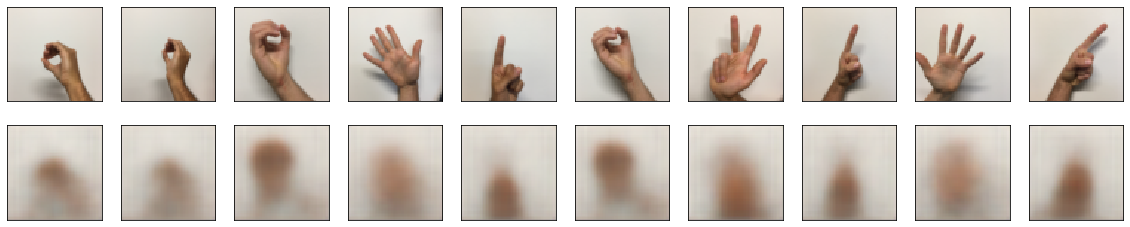

In [425]:
encoded_imgs = signs_encoder.predict(X_test)
decoded_imgs = signs_decoder.predict(encoded_imgs)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [156]:
# plot_model(mnist_autoencoder, show_shapes=True, to_file='mnist_autoencoder.png')
# plot_model(mnist_encoder,     show_shapes=True, to_file='mnist_encoder.png')
# plot_model(mnist_decoder,     show_shapes=True, to_file='mnist_decoder.png')

# mnist_autoencoder.summary()
# mnist_encoder.summary()
# mnist_decoder.summary()

In [ ]:

# input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

# x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# encoded = MaxPooling2D((2, 2), padding='same')(x)

# # at this point the representation is (4, 4, 8) i.e. 128-dimensional

# x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(16, (3, 3), activation='relu')(x)
# x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# autoencoder = Model(input_img, decoded)
# autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

---
---
---